# Task II: Classical Graph Neural Network (GNN)
### Task objectives:
- Use ParticleNet’s data for Quark/Gluon jet classification available
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons.
- Discuss the resulting performance of the architectures. 

### Approach:
##### Neural Networks:
I will tackle the problem at hand using three main different architecures:
1. A simple Deep Neural Network architecure: To have a solid reference point to the performance of the other two
2. A Graph Neural Network with a physics huiristic approach: Based on a common GNN structure, I utilize an affinity propagation clustering algorithm to mimic 
    the truth level [Lund string model](https://en.wikipedia.org/wiki/Lund_string_model). The model is suitable for our use case since we are concerned with the hadronization and fragmantation of the particles.
    
    The affinity clustering will connect the jet sub-structure together, event by event, while the global graph layer will connect the sub-structures across the batches/events to give a prediction on the nature of the event distribution, that is, an insight on the gluon/quark discrimination.

3. A Particle Flow Netowrk which is tailor made for jet classification [https://arxiv.org/abs/1810.05165](arXiv:1810.05165)

##### Data Preparation:
To have an even ground for all three classifiers, the same data preperation is used across all tests.
For specifity, I lay down here all the pre-processing manipulations:
1. The jets in each event are sorted by their transverse moemntum $p^i_T$. Here $i$ refers to the jet number.
<!-- 2. The transverse moemntum $p^i_T$ is normalized by the event total transverse momentum $p^\text{tot}_T = \sum_i p^i_T$ across each event, and by min-max normalization across the sample. This choice is motivated by:
   1. Normalizing across the event keeps the features under control and closer in the learning phase space.
   2. Normalizing across the sample keeps event-event contranst that is lost by the first normalization. Since the data is generated in the range of $p_T^\text{jet}\in[500,550]$ GeV and as such no outliers are expected and I opt for min-max over Z-score normalization -->
2. The event (all jet constituents) are rotated to $\pi$ using the angle of the total transverse momentum of the event $\phi^\text{tot}$. This helps the huiristic GNN graph preparation deal with jets close or at the boundaries of $[0,2\pi)$. Furthermore, it seems like a similar approach is used for [https://energyflow.network/examples/](PFNs)
3. Particle ID information essentially holds mass $m$ and charge $q$ information but in discrete form. This information is converted to a one continuous and one discrete information using:
    - Particle transverse energy $E_T$, using the mass-energy equivalence $\sqrt{m^2 + p_T^2}$
    - And the charge itself $q$

Note: $p_T^\text{tot}$ can never be zero, since the gluon/quark is recoiling agains the Z Boson. Essentially, $p_T^\text{tot}$ is the missing transverse energy of the two neutrinos.

##### Layout:
In this notebook, I will go through each of the following step separately and layout my understanding in a form of a discussion:
- Section 1: Data investigation and preparation
- Section 2: Neural networks model building and trining
- Section 3: Neural networks comparisons
- Section 4: Summary

**Note:** Please change the directory path in the first cell, such that it points to the dataset directory. Also, note that some cells need to be changed by hand, please read the comments carefully.

## Section 1: Data investigation and preparation
Side note: I noticed that the values of $\phi$ can lie outside the range $[0,2\pi)$!! This is weird to say the least. The convention as far as I know is either $[0,2\pi)$ or $[-\pi,\pi)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
import awkward as ak
import sklearn as sk
import pdg
import awkward as ak
import networkx as nx
import random
import warnings
from silence_tensorflow import silence_tensorflow
# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

silence_tensorflow()
warnings.filterwarnings('ignore')
pdg = pdg.connect(pedantic=True)

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

dir = '/PATH/TO/3164691/'

2025-04-08 19:37:49.108043: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 19:37:49.120960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744133869.134586 2105364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744133869.138824 2105364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744133869.150952 2105364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

##### Explanation for the next cell:
- In the following cell, the data is loaded and saved as a dataframe to simplify further manipulations and to shrink the dataset size.
- To split the data into training, validation and testing, the dataframe index values are used. This means that the shuffling of the data at the end of the cell is essential to randomize the training and batched events
- Information about the particle id is stored in `pid_X` columns, where `X` is the jet number
- Information about jet origin (gluon/quark) is stored in `qgid` column
- Information about the inclusion of b/c-quark in the simulation is stored in `bcid` column.

In [ ]:
# skip this cell if you have data in disk

# Due to the large size of the data, I opted for a reduced type precision whenever possible
# The total data with compression is ~8 GB, but without compression (in memory) can reach up to ~20 GB
# To reduce the size, I down-casted the jet origin (gluon,quark) to boolean and float64 data to float32
# This will reduce the input data approximately by 1/2
# If you would like to keep using high precision float64, please change line (*)
# If you would like to keep int64 instead of boolean, please change line (**)
# Furthermore, due to the ragged shape of the input, I opted to use a dataframe with sparse dtype
# Meaning that whenever float32 0.0 is encountered, it is ignored (not stored)
# This reduces the memory usage significantly
# If you would like to implement regular dtypes, please change line (***)

# Let's take QG_jets_11.npz as an example.
# Compressed in disk:               102 MB
# Loaded in memeory:                408 MB
# Casting float64 -> float32:       230 MB
# Casting jet origin to boolean:    229 MB
# Applying sparse dataframe types:  139 MB

# particle id (pid) is casted to float32 as well, since the pid can go larger than 1E7
# casting to int32 is useless, as it has the same size as float32

df = pd.DataFrame()
floatType = np.float32 # (*)
counter = 0 #for testing only
for file in os.listdir(dir):
    if ".npz" not in file: continue
    bc_quark_id = 1 if "bc" in file else 0
    data = np.load(dir+file)
    Nevents   = data['X'].shape[0]
    NjetMax   = data['X'].shape[1]
    Nfeatures = data['X'].shape[2]

    # make event features and sort jets by their pT value
    event_features = np.reshape(data['X'],(Nevents,NjetMax*Nfeatures))
    event_features = event_features.reshape( event_features.shape[0],
                                            int((event_features.shape[-1]/4)),
                                            4 ) # for sorting
    sort_indices = np.argsort(event_features[:,:,0])[:,::-1] # descending order
    for i in range(len(sort_indices)): event_features[i] = event_features[i][sort_indices[i]]
    event_features = event_features.reshape( event_features.shape[0], event_features.shape[1]*event_features.shape[2] )
    event_id = data['y'][:,None]
    event_bc_quark = np.array([bc_quark_id]*len(data['y']))[:,None]

    # prepare and create dataframe
    data = np.append(event_id,event_bc_quark,axis=1)
    data = np.append(data,event_features,axis=1)
    data = pd.DataFrame(data)
    qg_col      = data.columns[0]
    bc_col      = data.columns[1]
    feature_col = data.columns[2:]

    data[qg_col]  = data[qg_col].astype(bool) # (**)
    data[bc_col]  = data[bc_col].astype(bool) # (**)
    data[feature_col] = data[feature_col].astype(floatType)

    df = pd.concat([df,data],ignore_index=True)
    df = df.fillna(0)
    df[feature_col] = df[feature_col].astype(pd.SparseDtype(floatType, 0)) # (***)

    print( 'file: %s, df mem: %.2f GB' % (file, df.memory_usage().sum()/1000/1000/1000) )

    #for testing only
    #counter += 1
    #if counter == 4: break
del data

new_col = ['qgid']
new_col += ['bcid']
for i in range(int(len(df.columns[1:]-1)/4)):
    new_col += ['pt_'+str(i)]
    new_col += ['eta_'+str(i)]
    new_col += ['phi_'+str(i)]
    new_col += ['pid_'+str(i)]
df.columns = new_col

# shuffle the events by sampling
df = df.sample(frac=1)
df = df.reset_index(drop=True)

In [2]:
# Save the dataset or a sampled version of it to disk
# depending on the computational resources at hand, adjust the 
# fraction or the number of processed events
# this can be skipped if not needed

# Note: jupyter is very bad at working with memory and garbage collection does not work properly
# it will probably be better to save the sample the data then restart the notebook, and instead of loading the whole
# dataframe, load the sampled version from disk

# I chose 100k sample (1/4 of the data), which should be sufficient to get a good overview of the networks peformance

#df = df.sample(100000)#(frac=1)
#df = df.reset_index(drop=True)
#df.to_pickle("data_downSampled.pickle")

# Read dataset from disk if saved
df = pd.read_pickle("data_downSampled.pickle")
df

,qgid,bcid,pt_0,eta_0,phi_0,pid_0,pt_1,eta_1,phi_1,pid_1,...,phi_150,pid_150,pt_151,eta_151,phi_151,pid_151,pt_152,eta_152,phi_152,pid_152
0,False,False,61.311317,1.159295,1.957609,-211.0,56.58157,1.158809,1.97614,211.0,...,0,0,0,0,0,0,0,0,0,0
1,True,False,111.390846,0.93446,1.01186,-2212.0,87.446877,0.938307,0.967488,-211.0,...,0,0,0,0,0,0,0,0,0,0
2,False,True,76.877205,0.110257,4.326829,2112.0,44.135128,0.111178,4.320437,211.0,...,0,0,0,0,0,0,0,0,0,0
3,True,False,176.259338,0.504214,2.491761,-211.0,143.5504,0.508978,2.491412,22.0,...,0,0,0,0,0,0,0,0,0,0
4,True,False,104.125381,0.05093,5.188859,-211.0,95.366112,0.052682,5.191886,22.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,96.900818,0.524514,6.122446,130.0,83.39299,0.517746,6.124117,130.0,...,0,0,0,0,0,0,0,0,0,0
99996,False,False,100.00061,1.254317,1.873529,211.0,45.796814,1.237101,1.891603,22.0,...,0,0,0,0,0,0,0,0,0,0
99997,False,True,111.031654,0.930205,1.681946,-211.0,76.805725,0.924981,1.684518,211.0,...,0,0,0,0,0,0,0,0,0,0
99998,True,False,205.408127,0.899328,0.982639,-321.0,75.422554,0.898188,0.992138,321.0,...,0,0,0,0,0,0,0,0,0,0


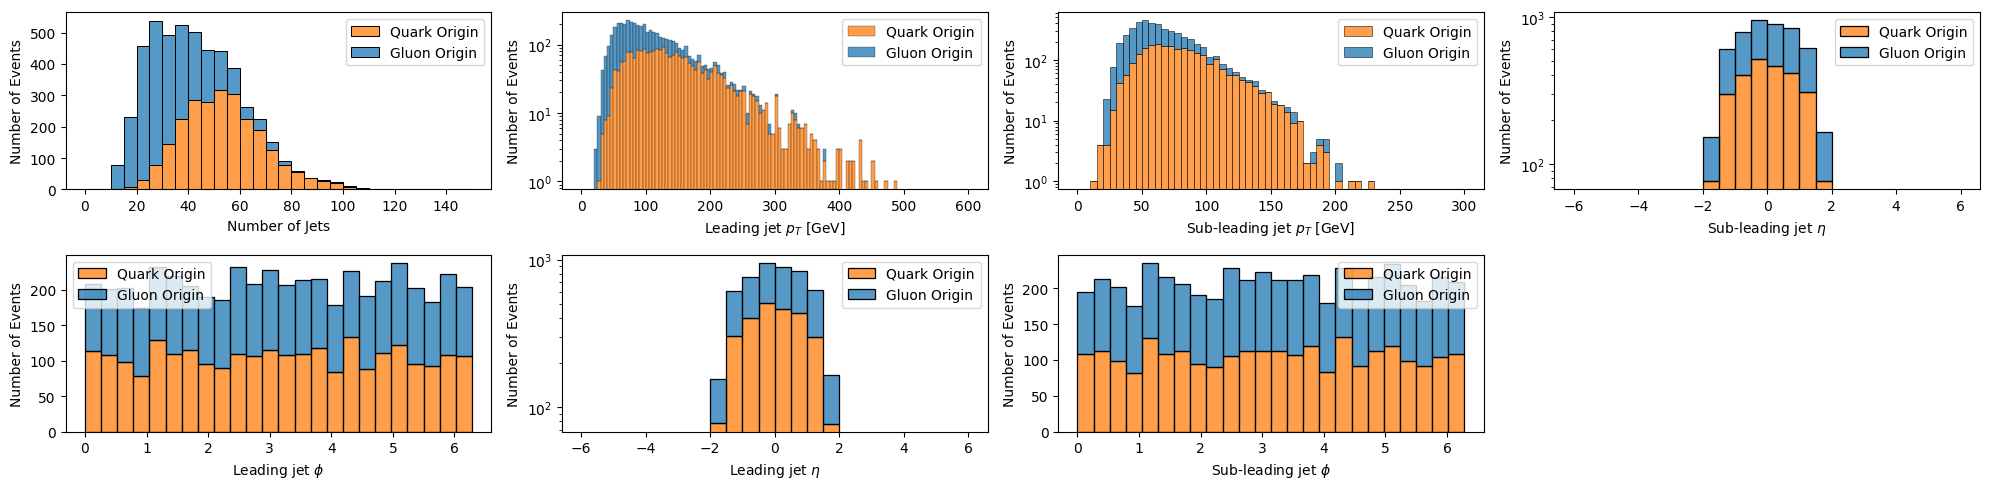

In [3]:
# Before proceeding further into treating the data, let's investigate the dataset by plotting a sampled histograms

fig, ax = plt.subplots(2,4,figsize=(20,5))

df_sample = df.sample(5000)
Njets_quark = (df_sample[df_sample['qgid']][df.columns[2::4]] != 0).to_numpy()
Njets_quark = np.sum(Njets_quark,axis=-1)
Njets_gluon = (df_sample[~df_sample['qgid']][df.columns[2::4]] != 0).to_numpy()
Njets_gluon = np.sum(Njets_gluon,axis=-1)

tax = ax[0,0]
sns.histplot(data=[Njets_quark, Njets_gluon], multiple='stack', binrange=(0,150), binwidth=5, ax=tax)
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Number of Jets')
tax.set_ylabel('Number of Events')

tax = ax[0,1]
sns.histplot(data=df_sample, x='pt_0', hue='qgid', multiple='stack', binrange=(0,600), binwidth=5, ax=tax)
tax.set_yscale('log')
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Leading jet $p_T$ [GeV]')
tax.set_ylabel('Number of Events')

tax = ax[1,0]
sns.histplot(data=df_sample, x='phi_0', hue='qgid', multiple='stack', binrange=(0,2*np.pi), binwidth=np.pi/12, ax=tax)
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Leading jet $\\phi$')
tax.set_ylabel('Number of Events')

tax = ax[1,1]
sns.histplot(data=df_sample, x='eta_0', hue='qgid', multiple='stack', binrange=(-6,6), binwidth=.5, ax=tax)
tax.set_yscale('log')
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Leading jet $\\eta$')
tax.set_ylabel('Number of Events')

tax = ax[0,2]
sns.histplot(data=df_sample, x='pt_1', hue='qgid', multiple='stack', binrange=(0,300), binwidth=5, ax=tax)
tax.set_yscale('log')
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Sub-leading jet $p_T$ [GeV]')
tax.set_ylabel('Number of Events')

tax = ax[1,2]
sns.histplot(data=df_sample, x='phi_1', hue='qgid', multiple='stack', binrange=(0,2*np.pi), binwidth=np.pi/12, ax=tax)
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Sub-leading jet $\\phi$')
tax.set_ylabel('Number of Events')

tax = ax[0,3]
sns.histplot(data=df_sample, x='eta_1', hue='qgid', multiple='stack', binrange=(-6,6), binwidth=.5, ax=tax)
tax.set_yscale('log')
tax.legend(['Quark Origin','Gluon Origin'])
tax.set_xlabel('Sub-leading jet $\\eta$')
tax.set_ylabel('Number of Events')

ax[1,3].xaxis.set_visible(False)
ax[1,3].yaxis.set_visible(False)
for spine in ['top', 'right', 'left', 'bottom']:
   ax[1,3].spines[spine].set_visible(False)

fig.tight_layout()

In [4]:
# Taking phi_0 as an example. the minimum value seem to be negative, and the maximum value seem to be larger than 2*pi!
df['phi_0'].min(), df['phi_0'].max()

(-0.1981926, 6.523684)

In the following cells I investigate the unique `pid` values constituting the dataset and find that it contains only a handful of particles, namely:
- Hadrons and mesons: protons, neutrons, kaons, pions and their anti-particles if exist
- Fermions: electrons, muons and their anti-particles
- Bosons: photons

Using this information, I utilize the particle data group library (PDG) to fetch each particle information and extend the event features by adding the $E_T$ and $q/p^{\text{tot}}_T$ information as discussed at the beginning of the notebook.

*Note: * Photons and Neutral long-lived Kaons do not have an assigned mass. As such, I set the photon mass to zero and the K0L mass to K0. Both decisions are sound from a physics point of view.

In [5]:
# check for unique pids
unique_pid = np.array([])
for pid_col in df.columns[5::4]:
    unique_pid = np.append(unique_pid, df[pid_col].unique().to_numpy())

unique_pid = np.unique(unique_pid).astype(int)
unique_pid = unique_pid[unique_pid!=0]# remove 0 as it is not a particle
print('The following is the set of all pids:\n', unique_pid)

The following is the set of all pids:
 [-2212 -2112  -321  -211   -13   -11    11    13    22   130   211   321
  2112  2212]


In [6]:
# construct a pid dictionary containing mass and charge
pid_extra_info = {}
for pid in unique_pid:
    charge = pdg.get_particle_by_mcid(int(pid)).charge
    if pid == 22:
        mass = 0
    elif pid == 130:
        mass = pdg.get_particle_by_mcid(321).mass
    else:
        mass = pdg.get_particle_by_mcid(int(pid)).mass

    pid_extra_info[int(pid)] = {'mass': mass, 'charge': charge}

# manually add pid of 0 for non-existing jets with mass 0 and charge 0, this will simplify the manipulations in the following cell
pid_extra_info[int(0)] = {'mass': 0, 'charge': 0}
print('The following is the set of all pids and their corresponding mass and charge:\n')
print(pid_extra_info)

The following is the set of all pids and their corresponding mass and charge:

{-2212: {'mass': 0.93827208816, 'charge': -1.0}, -2112: {'mass': 0.93956542052, 'charge': 0.0}, -321: {'mass': 0.49367659945804093, 'charge': -1.0}, -211: {'mass': 0.139570390983681, 'charge': -1.0}, -13: {'mass': 0.1056583755, 'charge': 1.0}, -11: {'mass': 0.0005109989499999999, 'charge': 1.0}, 11: {'mass': 0.0005109989499999999, 'charge': -1.0}, 13: {'mass': 0.1056583755, 'charge': -1.0}, 22: {'mass': 0, 'charge': 0.0}, 130: {'mass': 0.49367659945804093, 'charge': 0.0}, 211: {'mass': 0.139570390983681, 'charge': 1.0}, 321: {'mass': 0.49367659945804093, 'charge': 1.0}, 2112: {'mass': 0.93956542052, 'charge': 0.0}, 2212: {'mass': 0.93827208816, 'charge': 1.0}, 0: {'mass': 0, 'charge': 0}}


In [7]:
# calculate pT_total and phi_total using vectorial sum

cols = df.columns
Nparticle = int(len(cols[2:])/4)
def tot_pT_phi (pT,phi):
    pTx = pT * np.cos(phi)
    pTy = pT * np.sin(phi)
    
    pTx = pTx.sum(axis=1)
    pTy = pTy.sum(axis=1)

    pT = np.sqrt(pTx**2 + pTy**2)
    phi = -1 * ( np.arctan2(pTy,-1*pTx) - np.pi )

    return pT[:,None], phi[:,None]

pT, phi = tot_pT_phi(df[cols[2::4]].to_numpy(), df[cols[4::4]].to_numpy())
pT, phi = pd.DataFrame(pT,columns=['pT']), pd.DataFrame(phi,columns=['phi'])

In [8]:
# workaround sparse columns since df.loc[] does not work for this data type
def sp_loc(df, index, columns, val):
    # source: https://stackoverflow.com/questions/49032856/assign-values-to-sparsearray-in-pandas
    # Save the original sparse format for reuse later
    spdtypes = df.dtypes[columns]

    # Convert concerned Series to dense format
    df[columns] = df[columns].sparse.to_dense()

    # Do a normal insertion with .loc[]
    df.loc[index, columns] = val

    # Back to the original sparse format
    df[columns] = df[columns].astype(spdtypes)

def rotate_frame(df, phi_ref, phi_cols):
    #rotate phii (phi jet) according to phi_ref
    c = np.pi - phi_ref # move phi_ref -> pi
    c = c.to_numpy()[:,0]

    for phii in tqdm(phi_cols):
        #flag non-zero phi values
        flagZero = df[phii] != 0

        #rotation conditions
        #1) \Delta>=2*pi
        condition = (flagZero) & (df[phii] + c >= 2*np.pi)
        if condition.sum()>0:
            sp_loc(df,condition,phii,df[condition][phii] + c[condition] - 2*np.pi)
        #1) \Delta<0
        condition = (flagZero) & (df[phii] + c < 0)
        if condition.sum()>0:
            sp_loc(df,condition,phii,df[condition][phii] + c[condition] + 2*np.pi)
        #2) 0<=\Delta<2*pi
        condition = (flagZero) & (df[phii] + c < 2*np.pi) & (df[phii] + c >= 0)
        if condition.sum()>0:
            sp_loc(df,condition,phii,df[condition][phii] + c[condition])

In [9]:
# Do not interupt the function.
# If interupted, the data has to be loaded again
rotate_frame(df,phi,cols[4::4])

100%|██████████| 153/153 [01:09<00:00,  2.19it/s]


In [10]:
pidToMass = lambda x: pid_extra_info[x]['mass']
pidToCharge = lambda x: pid_extra_info[x]['charge']
ET = lambda m, pT: np.sqrt(m**2+pT**2)

#add all additional information to the dataframe
for i in range(Nparticle):
    pT = df[ cols[2+4*i] ]
    pid = df[ cols[5+4*i] ]

    mass = pid.astype(int).apply(pidToMass)
    charge = pid.astype(int).apply(pidToCharge)

    df['ET_'+str(i)] = ET(mass,pT).astype(pd.SparseDtype(np.float32, 0))
    df['charge_'+str(i)] = charge.astype(pd.SparseDtype(np.int8, 0))

# rearrange dataframe and drop pid columns as they are no longer needed
id_cols = df.columns[:2].to_numpy()
old_jet_cols = df.columns[2:len(cols)].to_numpy()
extra_cols = df.columns[len(cols):].to_numpy()

extra_cols = extra_cols.reshape(int(len(extra_cols)/2),2)
old_cols = old_jet_cols.reshape(int(len(old_jet_cols)/4),4)
old_cols = old_cols[:,:-1] # drop pid numbers

rearranged_cols = np.concatenate([old_cols,extra_cols], axis=1)
rearranged_cols = np.concatenate([id_cols,rearranged_cols.flatten()])
rearranged_cols

df = df[rearranged_cols]

In [11]:
# Inspect the dataframe after manipulation
df

,qgid,bcid,pt_0,eta_0,phi_0,ET_0,charge_0,pt_1,eta_1,phi_1,...,pt_151,eta_151,phi_151,ET_151,charge_151,pt_152,eta_152,phi_152,ET_152,charge_152
0,False,False,61.311317,1.159295,3.089135,61.311478,-1,56.58157,1.158809,3.107666,...,0,0,0,0,0,0,0,0,0,0
1,True,False,111.390846,0.93446,3.172774,111.394798,-1,87.446877,0.938307,3.128401,...,0,0,0,0,0,0,0,0,0,0
2,False,True,76.877205,0.110257,3.154754,76.882942,0,44.135128,0.111178,3.148362,...,0,0,0,0,0,0,0,0,0,0
3,True,False,176.259338,0.504214,3.144782,176.259384,-1,143.5504,0.508978,3.144433,...,0,0,0,0,0,0,0,0,0,0
4,True,False,104.125381,0.05093,3.149072,104.125473,-1,95.366112,0.052682,3.1521,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,96.900818,0.524514,3.147422,96.902077,0,83.39299,0.517746,3.149093,...,0,0,0,0,0,0,0,0,0,0
99996,False,False,100.00061,1.254317,3.13391,100.00071,1,45.796814,1.237101,3.151984,...,0,0,0,0,0,0,0,0,0,0
99997,False,True,111.031654,0.930205,3.09965,111.031746,-1,76.805725,0.924981,3.102222,...,0,0,0,0,0,0,0,0,0,0
99998,True,False,205.408127,0.899328,3.136616,205.408722,-1,75.422554,0.898188,3.146116,...,0,0,0,0,0,0,0,0,0,0


In [12]:
pt_col, eta_col, phi_col = df.columns[2::5], df.columns[3::5], df.columns[4::5]

In [ ]:
# skip this cell if you have data in disk

# The following awkward matrix (adjacancy list) will be used later on in the first GNN model
# The GNN will use clustering via affinity propegation to connect the graph
# here I used scikit learn clustering algorithm to achieve this goal

# Some events will have poor convergence. One can lower the tolerence by increasing the damping value [0.5,1.0), where the default is 0.5.
# I have chosen not to increase it above 0.6 to have the algorithm well under control. Large damping will result in fewer large clusters. 
coordinates = np.concatenate([df[eta_col].to_numpy()[:,:,None], df[phi_col].to_numpy()[:,:,None]], axis=2)
adjacancy_list = ak.Array([])
adjacancy_list_placeHolder = [] #postpone ak.concatenate until the end, since ak.concatenate is horoundously slow with large arrays
counter=0 #for testing only
NsingleJet=0 # track single jet events
for i in tqdm( range(len(coordinates)) ):
    coord = coordinates[i][coordinates[i].sum(axis=1)!=0]

    if len(coord)<2:
        NsingleJet += 1
        adjacancy_list_placeHolder +=[np.array([[[0,0]]]).astype(np.int32)]
        continue

    affProp = sk.cluster.AffinityPropagation(max_iter=10000,damping=0.6).fit(coord)
    centers = affProp.cluster_centers_indices_
    labels = affProp.labels_

    #periphery to center connections, including self connections
    adjacancy_list_placeHolder += [ np.array([ [int(centers[labels[peripheryIndex]]),peripheryIndex] for peripheryIndex in range(len(labels)) ])[None,:] ] # [cluster_center,periphery] 

    #center to center connections
    #cluster_centers_connection = []
    #for i in range(len(centers)):
    #    for j in range(i+1, len(centers)):
    #        cluster_centers_connection += [int(centers[i]), int(centers[j])]
    #adjacancy_list_placeHolder += [[ np.array([cluster_centers_connection])[None,:] ]] #--> Needs to be fixed first

    #for testing only
    #counter += 1
    #if counter == 5: break
adjacancy_list = ak.concatenate(adjacancy_list_placeHolder,axis=0)
adjacancy_list

In [14]:
# save the graph adjacancy list or load it if it already exist and if necessary
#ak.to_feather(adjacancy_list,'adjacancy_list_affProp_downSampled.feather')
adjacancy_list = ak.from_feather('adjacancy_list_affProp_downSampled.feather')

Text(0.5, 1.0, 'Graph Representation')

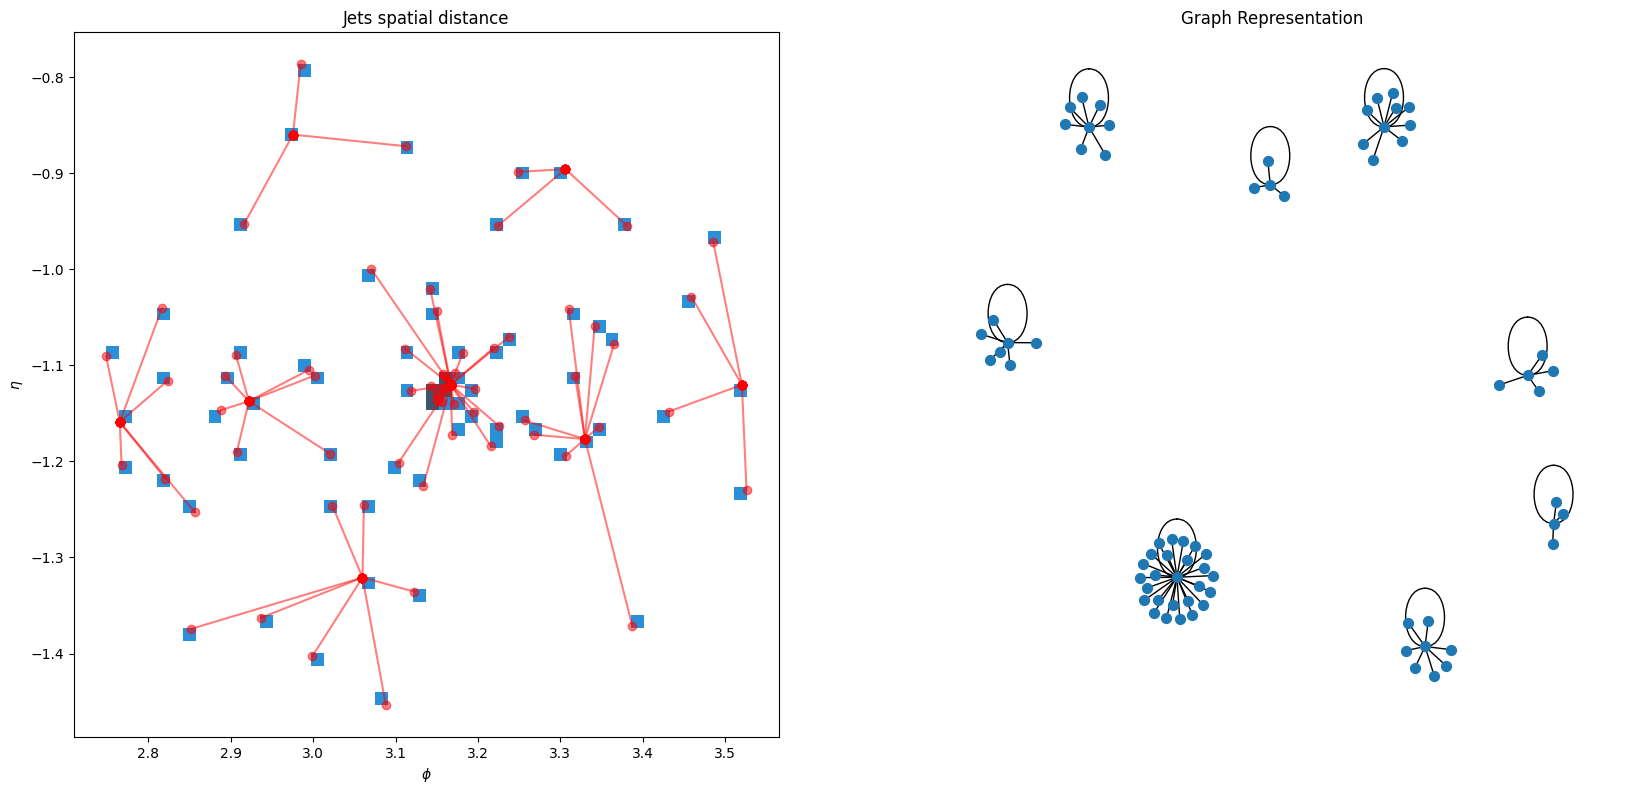

In [20]:
# pick a random event and plot its graph representation

rEvent = np.random.randint(0,len(adjacancy_list)-1)
rEvent_adj = adjacancy_list[rEvent]
eta, phi = df[eta_col].iloc[rEvent], df[phi_col].iloc[rEvent]
eta, phi = np.array(eta), np.array(phi)
eta, phi = eta[eta!=0], phi[phi!=0]

fig, ax = plt.subplots(1,2,figsize=(10*2, 10))
ax[0].set_box_aspect(1)
ax[1].set_box_aspect(1)
sns.histplot(x=phi,y=eta,bins=50,ax=ax[0])
for i in range(len(rEvent_adj)):
    for j in range(len(rEvent_adj[0])):
        ax[0].plot( [ phi[rEvent_adj[i][0]], phi[rEvent_adj[i][j]] ], [ eta[rEvent_adj[i][0]], eta[rEvent_adj[i][j]] ], 'ro-',alpha=0.5)
ax[0].set_title("Jets spatial distance")
ax[0].set_xlabel('$\\phi$')
ax[0].set_ylabel("$\\eta$")

# Plot the graph connections (adjacancy)
import networkx as nx
adjacancy = np.zeros((np.max(rEvent_adj+1),np.max(rEvent_adj+1)))
for c in rEvent_adj:
    for j in range(1,len(c)):
        adjacancy[c[0],c[j]] = 1

G = nx.Graph(adjacancy)
nx.draw(G,node_size=50,ax=ax[1])
ax[1].set_title("Graph Representation")

## Section 2: Network model building

In [21]:
# Regular DNN layer
class MLP(tf.keras.Model):
    def __init__(self,depth_width,regularization=None,batchNorm=None, dropout=0.2):
        super().__init__()
        self.layers_ = []
        self.depth_width = (depth_width,) if type(depth_width)==int else depth_width
        for unit in range(len(self.depth_width)):
            self.layers_ += [ tf.keras.layers.Dense(self.depth_width[unit], activation="relu") ]
            if regularization: self.layers_ += [ tf.keras.layers.ActivityRegularization() ]
            if batchNorm: self.layers_ += [ tf.keras.layers.BatchNormalization() ]
            if dropout: self.layers_ += [ tf.keras.layers.Dropout(dropout) ]

    def call(self, inputs):
        x = inputs
        for i in range(len(self.layers_)):
            x = self.layers_[i](x)
        return x

# Regular DNN layer but with reduction on processed output
class MLPwithReduction(tf.keras.Model):
    def __init__(self,depth_width,regularization=None,batchNorm=None, dropout=0.2):
        super().__init__()
        self.layers_ = []
        self.depth_width = (depth_width,) if type(depth_width)==int else depth_width
        for unit in range(len(self.depth_width)):
            self.layers_ += [ tf.keras.layers.Dense(self.depth_width[unit], activation="relu") ]
            if regularization: self.layers_ += [ tf.keras.layers.ActivityRegularization() ]
            if batchNorm: self.layers_ += [ tf.keras.layers.BatchNormalization() ]
            if dropout: self.layers_ += [ tf.keras.layers.Dropout(dropout) ]

    def call(self, inputs):
        x = inputs
        for i in range(len(self.layers_)):
            x = self.layers_[i](x)
        x = x[:,:,0]
        return x

# Recurrent neural network layer
class RecurrentSimpleModel(tf.keras.Model):
    def __init__(self,units, mask=True, regularization=None, batchNorm=None, dropout=0.2):
        super().__init__()
        self.layers_ = []
        if mask: self.layers_ += [ tf.keras.layers.Masking(mask_value=0.0) ]
        self.layers_ += [ tf.keras.layers.SimpleRNN(units) ]
        if regularization: self.layers_ += [ tf.keras.layers.ActivityRegularization() ]
        if batchNorm: self.layers_ += [ tf.keras.layers.BatchNormalization() ]
        if dropout: self.layers_ += [ tf.keras.layers.Dropout(dropout) ]

    def call(self, inputs):
        x = inputs
        for i in range(len(self.layers_)):
            x = self.layers_[i](x)
        return x
# Regular DNN model to be used for comparison
class DNN(tf.keras.Model):
    def __init__(
        self,
        MLP_depth_width,
        output_dim=1,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.MLP_depth_width = MLP_depth_width
        self.output_dim = output_dim
        
        self.MLP = MLP(self.MLP_depth_width)
        self.output_ = tf.keras.layers.Dense(self.output_dim, activation='sigmoid')
    
    def call(self,inputs):
        x = inputs
        x = self.MLP(x)
        x = self.output_(x)
        return x

# GCN layer/model using the previously initiated networks
class GCNLayer(tf.keras.Model):
    def __init__(self,depth_width=(None,None),firstLayerType='dense'):
        super().__init__()
        self.depth_width = depth_width
        self.firstLayerType = firstLayerType

        if self.depth_width[0]:
            if self.firstLayerType == 'recurrent':
                self.simpleModel_0 = RecurrentSimpleModel(self.depth_width[0])
            elif self.firstLayerType == 'dense':
                self.simpleModel_0 = MLPwithReduction(self.depth_width[0])
            else:
                raise ValueError("Unsupported first layer type")
        
        if self.depth_width[1]:
            self.simpleModel_1 = MLP(self.depth_width[1])
        
    # Pass messages from nodes to edges using the mean of the two nodes: A<->B = mean(A,B)
    def edge_aggregation(self, node_embeding, node_adjacancy):
        aggregation = tf.gather(node_embeding,node_adjacancy,axis=1,batch_dims=1)# shape=(Batch,None,2)
        aggregation = tf.reduce_mean(aggregation,axis=-1)# shape=(Batch,None)
        return aggregation
    
    # Workaround ragged tensors, so that it is possible to process the adjacancy list with ease
    def tensor_raggedReplace(self,tensor,indices,values):
        #replace tensor shape (dense) with values (ragged) using indices (ragged)
        zero_tensor = tf.zeros_like(tensor, dtype=tensor.dtype)
        
        updated_rows = tf.tensor_scatter_nd_add(zero_tensor[0],indices[0][:,None],values[0])[None,:]
        for row, idx, value in zip(zero_tensor[1:],indices[1:],values[1:]):
            row = tf.tensor_scatter_nd_add(row,idx[:,None],value)
            updated_rows = tf.concat([updated_rows,row[None,:]],axis=0)
        
        updated_tensor = tf.constant(updated_rows)
        return updated_tensor

    # custom keras update loop to be used with ragged tensors
    def tf_while_loop_update(self, tensor, indices, values):
        # Initialize the accumulator for updated rows
        zero_tensor = tf.zeros_like(tensor,dtype=tensor.dtype)
        updated_rows = tf.TensorArray(dtype=tensor.dtype, size=0, dynamic_size=True, clear_after_read=False)
        i = tf.constant(0)
        
        #pass over all batches
        def condition(i, *args):
            return i < tf.shape(indices)[0]

        #update each patch node embeding using values and indices
        def body(i, updated_rows, zero_tensor):
            #fetch associated row, index and value
            row = zero_tensor[i]
            idx = indices[i]
            value = values[i]
            # append the updated node embedings to the accumulator
            row = tf.tensor_scatter_nd_add(row, idx[:, None], value)
            updated_rows = updated_rows.write(i, row)

            return i + 1, updated_rows, zero_tensor
        
        # Execute tf.while_loop
        _, updated_rows, _ = tf.while_loop(condition, body, loop_vars=[i, updated_rows, zero_tensor])

        #stack the accumulated rows to form the final tensor
        updated_rows = updated_rows.stack()
        return updated_rows

    # update the nodes using messages from edges
    def node_update(self, node_embeding, edge_messages, node_adjacancy):
        #first we sum edge_messages to target
        nodes_to_update = node_adjacancy[:,:,0]
        edge_to_node = self.tf_while_loop_update(node_embeding,nodes_to_update,edge_messages)
        #now we aggregate to nodes by addition
        node_embeding = tf.add(node_embeding,edge_to_node)

        #second we sum edge_messages to target
        nodes_to_update = node_adjacancy[:,:,1]
        edge_to_node = self.tf_while_loop_update(node_embeding,nodes_to_update,edge_messages)
        #now we aggregate to nodes by addition
        node_embeding = tf.add(node_embeding,edge_to_node)
        return node_embeding
    
    # Structure is: Nodes -> Model_0(Dense/Recurrent/...) -> Model_1(Dense/Recurrent/...) -> node to edge updates -> edge to node updates
    def call(self, inputs):
        node_embeding, node_adjacancy = inputs
        x = node_embeding
        if self.simpleModel_0: x = self.simpleModel_0(x)
        if self.simpleModel_1: x = self.simpleModel_1(x)
        edge_messages = self.edge_aggregation(x, node_adjacancy)
        x = self.node_update(x, edge_messages, node_adjacancy)
        return x

# Now the GNN is made. One GCN layer is used instead of two to save computational time
# Structure: inputs(nodes,edges) -> GCN layer -> Gloval MLP -> output
class GNN(tf.keras.Model):
    def __init__(
        self,
        dimensions,
        global_depth_width,
        GCLayer_depth_width,
        firstLayerType='denseReduced',
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.node_dim = dimensions[0]
        self.output_dim = dimensions[1]
        
        self.GCN_layer_0 = GCNLayer((GCLayer_depth_width[0],)+(self.node_dim,),firstLayerType=firstLayerType)
        #self.GCN_layer_1 = GCNLayer((GCLayer_depth_width[1],)+(self.node_dim,))
        self.global_MLP = MLP(global_depth_width)
        self.output_ = tf.keras.layers.Dense(self.output_dim, activation='sigmoid')
    
    @tf.function
    def test(self,tensor):
        if tf.shape(tensor)[0] == 0:
            print('Empty batch detected', tensor.shape)
    
    def call(self,inputs):
        node_features, node_adjacancy = inputs
        x = self.GCN_layer_0([node_features,node_adjacancy])
        #x = self.GCN_layer_1([x,node_adjacancy])
        x = self.global_MLP(x)
        x = self.output_(x)
        return x

In [40]:
# build the DNN
optimizer = tf.keras.optimizers.Nadam(0.0001)
loss = 'binary_crossentropy'
metrics = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
           tf.keras.metrics.AUC(name="AUC"),
           tf.keras.metrics.F1Score(name="F1")]
simpleDNN = DNN(MLP_depth_width=(512,256,143,128,64,32),output_dim=1)
simpleDNN.compile(
    optimizer=optimizer,
    loss=loss,
    loss_weights=None,
    metrics=metrics,
    weighted_metrics=None,
    run_eagerly=False,
    steps_per_execution=1,
    jit_compile="auto",
    auto_scale_loss=True,
)
# prepare the training and validation datasets and train the DNN

callbacks=[tf.keras.callbacks.CSVLogger('log.csv',append=True),
           tf.keras.callbacks.ReduceLROnPlateau(patience=5),
           tf.keras.callbacks.EarlyStopping('val_loss',patience=2)
           ]

test_df = df

train_selection = test_df[test_df.index % 3 == 0].index.to_list()
val_selection = test_df[test_df.index % 3 == 1].index.to_list()
test_selection = test_df[test_df.index % 3 == 2].index.to_list()

test_node_features = test_df[test_df.columns[2:]].values.astype(np.float32)
test_id = np.array(test_df['qgid'])[:,None].astype(np.float32)

# now train the DNN
history_simpleDNN = simpleDNN.fit(test_node_features[train_selection], test_id[train_selection],
                                    batch_size=512,
                                    epochs=40,
                                    verbose=1,
                                    callbacks=callbacks,
                                    validation_data=(test_node_features[val_selection], test_id[val_selection]),
                                    shuffle=True,
                                    class_weight=None,
                                    sample_weight=None,
                                    initial_epoch=0,
                                    steps_per_epoch=None,
                                    validation_steps=None,
                                    validation_batch_size=None,
                                    validation_freq=1
)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - AUC: 0.7201 - F1: 0.6687 - accuracy: 0.6923 - loss: 0.7558 - val_AUC: 0.8392 - val_F1: 0.6646 - val_accuracy: 0.7686 - val_loss: 0.4947 - learning_rate: 1.0000e-04
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.8408 - F1: 0.6687 - accuracy: 0.7683 - loss: 0.4919 - val_AUC: 0.8437 - val_F1: 0.6646 - val_accuracy: 0.7733 - val_loss: 0.4881 - learning_rate: 1.0000e-04
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8451 - F1: 0.6687 - accuracy: 0.7723 - loss: 0.4855 - val_AUC: 0.8460 - val_F1: 0.6646 - val_accuracy: 0.7747 - val_loss: 0.4848 - learning_rate: 1.0000e-04
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.8474 - F1: 0.6687 - accuracy: 0.7736 - loss: 0.4823 - val_AUC: 0.8466 - val_F1: 0.6646 - val_accuracy: 0.7759 - val_loss: 0.4837 - learning_rate: 1.0000e-04
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - AUC: 0.8489 - F1: 0.6687 - accuracy: 0.7768 - loss: 0.4803 - val_AUC: 0.8470 - 

In [44]:
#build the GNN network
optimizer = tf.keras.optimizers.Nadam(0.0001)
loss = 'binary_crossentropy'
metrics = [tf.keras.metrics.BinaryAccuracy(name="accuracy"),
           tf.keras.metrics.AUC(name="AUC"),
           tf.keras.metrics.F1Score(name="F1")]

# GNN with dense nodes
simpleGNN = GNN(dimensions=(153,1), GCLayer_depth_width=(128,None), firstLayerType='dense', global_depth_width=(512,256,64,32))
# GNN with recurrent nodes
#simpleGNN = GNN(dimensions=(153,1), GCLayer_depth_width=(512,None), firstLayerType='recurrent', global_depth_width=(64,32))
simpleGNN.compile(
    optimizer=optimizer,
    loss=loss,
    loss_weights=None,
    metrics=metrics,
    weighted_metrics=None,
    run_eagerly=False,
    steps_per_execution=1,
    jit_compile="auto",
    auto_scale_loss=True,
)

# prepare the training and validation datasets and train the GNN

# now convert the adjacancy list awkward array to a ragged tensor
# which can be processed by tensorflow
values = ak.flatten(adjacancy_list,axis=1)
values = np.array(values)
splits = np.array(ak.count(adjacancy_list,axis=1))[:,0]
splits = splits.cumsum()
splits = np.concatenate([[0],splits])
splits
tfAdjacancy_list = tf.RaggedTensor.from_row_splits(values,splits)

callbacks=[tf.keras.callbacks.CSVLogger('log.csv',append=True),
           tf.keras.callbacks.ReduceLROnPlateau(patience=5),
           tf.keras.callbacks.EarlyStopping('val_loss',patience=2)
           ]

test_df = df
tfAdjacancy_list = tfAdjacancy_list

train_selection = test_df[test_df.index % 3 == 0].index.to_list()
val_selection = test_df[test_df.index % 3 == 1].index.to_list()
test_selection = test_df[test_df.index % 3 == 2].index.to_list()


test_node_features = test_df[test_df.columns[2:]].values.astype(np.float32)
test_node_features = np.concatenate([test_node_features[:,0::5][:,:,None],
                                     test_node_features[:,1::5][:,:,None],
                                     test_node_features[:,2::5][:,:,None],
                                     test_node_features[:,3::5][:,:,None],
                                     test_node_features[:,4::5][:,:,None]], axis=-1)
test_adjacancy = tfAdjacancy_list
test_id = np.array(test_df['qgid'])[:,None].astype(np.float32)

# now train the GNN
history_simpleGNN = simpleGNN.fit([test_node_features[train_selection], tf.gather(test_adjacancy,train_selection)], test_id[train_selection],
                                    batch_size=512,
                                    epochs=40,
                                    verbose=1,
                                    callbacks=callbacks,
                                    validation_data=([test_node_features[val_selection], tf.gather(test_adjacancy,val_selection)], test_id[val_selection]),
                                    shuffle=True,
                                    class_weight=None,
                                    sample_weight=None,
                                    initial_epoch=0,
                                    steps_per_epoch=None,
                                    validation_steps=None,
                                    validation_batch_size=None,
                                    validation_freq=1
)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - AUC: 0.7657 - F1: 0.6687 - accuracy: 0.6175 - loss: 0.6529 - val_AUC: 0.8109 - val_F1: 0.6646 - val_accuracy: 0.7627 - val_loss: 0.5456 - learning_rate: 1.0000e-04
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 120ms/step - AUC: 0.8231 - F1: 0.6687 - accuracy: 0.7686 - loss: 0.5272 - val_AUC: 0.8290 - val_F1: 0.6646 - val_accuracy: 0.7663 - val_loss: 0.5089 - learning_rate: 1.0000e-04
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - AUC: 0.8362 - F1: 0.6687 - accuracy: 0.7707 - loss: 0.5007 - val_AUC: 0.8345 - val_F1: 0.6646 - val_accuracy: 0.7672 - val_loss: 0.5013 - learning_rate: 1.0000e-04
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - AUC: 0.8411 - F1: 0.6687 - accuracy: 0.7724 - loss: 0.4934 - val_AUC: 0.8369 - val_F1: 0.6646 - val_accuracy: 0.7676 - val_loss: 0.4978 - learning_rate: 1.0000e-04
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - AUC: 0.8437 - F1: 0.6687 - accuracy: 0.7743 - loss: 0.4892 - val_AUC: 0.

In [28]:
# setup the PFN network dataset

# The PFN model expect the data to be as follows (pT,eta,phi,pid) for optimal training
# for this, I use the old dataset without the custom manipulation. Instead, I use the PFN dedicated
# method

pfn_data = pd.read_pickle("data_downSampled.pickle")
pfn_labels = (pfn_data[pfn_data.columns[0]].values).astype(float)
pfn_labels = to_categorical(pfn_labels, num_classes=2)

pfn_data = pfn_data.values.astype(np.float32)
pfn_data = np.concatenate([pfn_data[:,2::4][:,:,None],
                           pfn_data[:,3::4][:,:,None],
                           pfn_data[:,4::4][:,:,None],
                           pfn_data[:,5::4][:,:,None]], axis=-1)

# preprocess by centering jets and normalizing pts (as in the PFN example)
for x in pfn_data:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

# handle particle id channel
remap_pids(pfn_data, pid_i=3)

print('Finished preprocessing')

Finished preprocessing


In [45]:
# setup PFN network and train it
# the model parameters were taken from the EnergyFlow repository example set
# https://energyflow.network/examples/#pfn_examplepy

# since passing metrics is a bit counter intuitive, I will only use the accuracy metric (default)

# network architecture parameters
Phi_sizes, F_sizes = (100, 100, 256), (100, 100, 100)

# network training parameters
num_epoch = 10
batch_size = 500

# do train/val/test split
X_train   = pfn_data[train_selection]
X_val     = pfn_data[val_selection]
X_test    = pfn_data[test_selection]
Y_train   = pfn_labels[train_selection]
Y_val     = pfn_labels[val_selection]
Y_test    = pfn_labels[test_selection]

print('Model summary:')

# build architecture
pfn = PFN(input_dim=pfn_data.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)

# now train the model
history_PFN = pfn.fit(X_train, Y_train,
                      epochs=num_epoch,
                      batch_size=batch_size,
                      validation_data=(X_val, Y_val),
                      verbose=1)

Model summary:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 4)]            0         []                            
                                                                                                  
 tdist_0 (TimeDistributed)   (None, None, 100)            500       ['input[0][0]']               
                                                                                                  
 activation_7 (Activation)   (None, None, 100)            0         ['tdist_0[0][0]']             
                                                                                                  
 tdist_1 (TimeDistributed)   (None, None, 100)            10100     ['activation_7[0][0]']        
                                                                             

In [46]:
# Let us look at the architecture of the DNN and the GNN as well
simpleDNN.summary(expand_nested=True,show_trainable=True)
simpleGNN.summary(expand_nested=True,show_trainable=True)

Model: "dnn_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ mlp_5 (MLP)                 │ ?                     │    589,039 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_21 (Dense)       │ (None, 512)           │    392,192 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_18 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_22 (Dense)       │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_19 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_23 (Dense)       │ (None, 143)           │     36,751 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_20 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_24 (Dense)       │ (None, 128)           │     18,432 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_21 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_25 (Dense)       │ (None, 64)            │      8,256 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_22 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_26 (Dense)       │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_23 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_27 (Dense)            │ (None, 1)             │         33 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 1,767,219 (6.74 MB)

 Trainable params: 589,072 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,178,147 (4.49 MB)

Model: "gnn_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ gcn_layer_2 (GCNLayer)      │ ?                     │     24,330 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ ml_pwith_reduction_2   │ ?                     │        768 │   Y   │
│ (MLPwithReduction)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ dense_28 (Dense)    │ (None, 153, 128)      │        768 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ dropout_24          │ ?                     │          0 │   -   │
│ (Dropout)                   │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ mlp_6 (MLP)            │ ?                     │     23,562 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ dense_29 (Dense)    │ (None, 153)           │     23,562 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│       └ dropout_25          │ ?                     │          0 │   -   │
│ (Dropout)                   │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mlp_7 (MLP)                 │ ?                     │    228,704 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_30 (Dense)       │ (None, 512)           │     78,848 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_26 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_31 (Dense)       │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_27 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_32 (Dense)       │ (None, 64)            │     16,448 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_28 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_33 (Dense)       │ (None, 32)            │      2,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dropout_29 (Dropout)   │ ?                     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_34 (Dense)            │ (None, 1)             │         33 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 759,204 (2.90 MB)

 Trainable params: 253,067 (988.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 506,137 (1.93 MB)

## Section 3: Neural networks comparison

In [47]:
# make predictions on the test dataset using each model
# DNN predictions
test_pred_df = test_df.iloc[test_selection]
DNN_prediction = simpleDNN.predict(test_pred_df[df.columns[2:]].to_numpy())
test_pred_df['pred_DNN_qgid'] = DNN_prediction

# GNN predictions
test_pred_node_features = test_node_features[test_selection]
test_pred_adjacancy = tf.gather(test_adjacancy,test_selection)
GNN_prediction = simpleGNN.predict([test_pred_node_features,test_pred_adjacancy])
test_pred_df['pred_GNN_qgid'] = GNN_prediction

# PFN predictions
preds = pfn.predict(X_test, batch_size=1000)
test_pred_df['pred_PFN_qgid'] = preds[:,1][:,None]

1042/1042 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
34/34 [==============================] - 3s 82ms/step


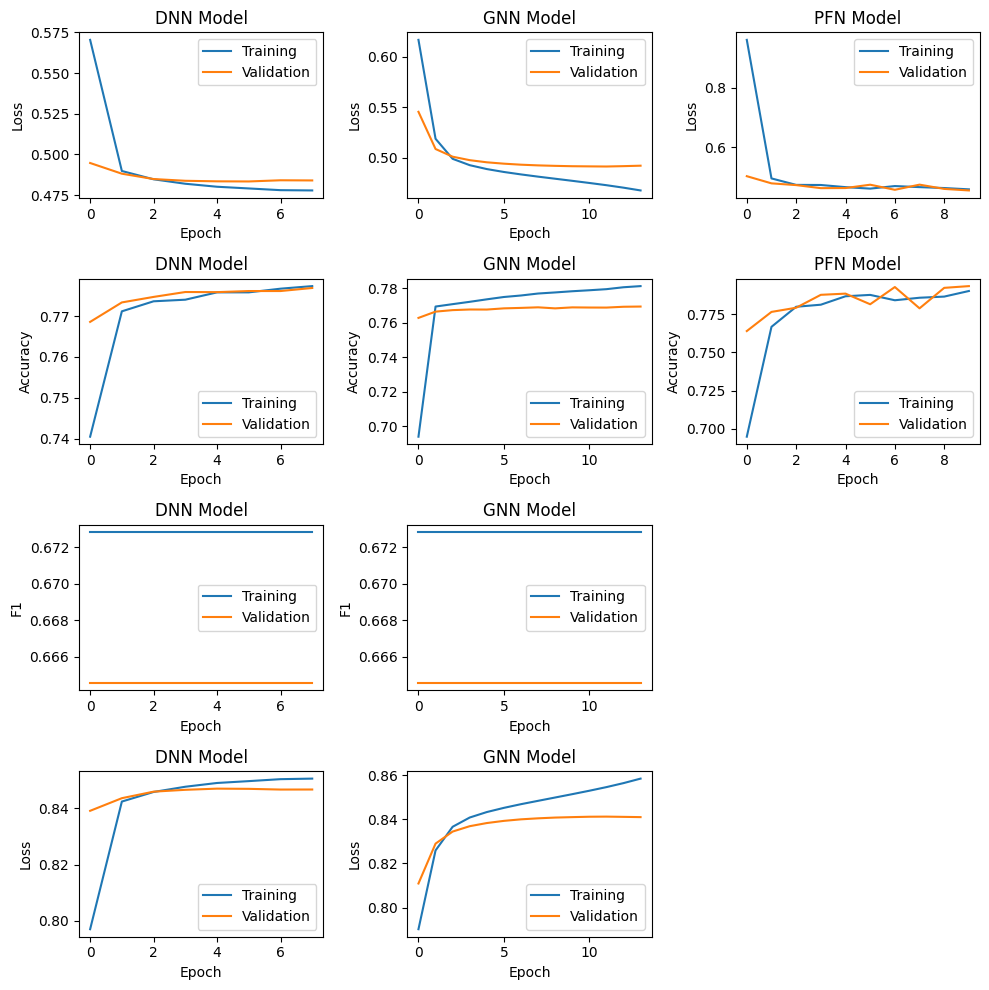

In [48]:
# As a sanity check, let us compare the training of each model
fig, ax = plt.subplots(4,3,figsize=(10,10))

label = {0:'DNN Model', 1:'GNN Model', 2:'PFN Model'}
history = {0: history_simpleDNN, 1: history_simpleGNN, 2: history_PFN}
for i in range(3):
    tax = ax[0,i]
    sns.lineplot(x='epoch', y='loss', data={'loss': history[i].history['loss'], 'epoch': history[i].epoch}, label="Training", ax=tax)
    sns.lineplot(x='epoch', y='loss', data={'loss': history[i].history['val_loss'], 'epoch': history[i].epoch}, label="Validation", ax=tax)
    tax.set_ylabel('Loss')
    tax.set_xlabel('Epoch')
    tax.set_title(label[i])

    if i==2: accuracy='acc'
    else: accuracy='accuracy'
    tax = ax[1,i]
    sns.lineplot(x='epoch', y='Accuracy', data={'Accuracy': history[i].history[accuracy], 'epoch': history[i].epoch}, label="Training", ax=tax)
    sns.lineplot(x='epoch', y='Accuracy', data={'Accuracy': history[i].history['val_'+accuracy], 'epoch': history[i].epoch}, label="Validation", ax=tax)
    tax.set_xlabel('Epoch')
    tax.set_title(label[i])

    if i==2: continue

    tax = ax[2,i]
    sns.lineplot(x='epoch', y='F1', data={'F1': history[i].history['F1'], 'epoch': history[i].epoch}, label="Training", ax=tax)
    sns.lineplot(x='epoch', y='F1', data={'F1': history[i].history['val_F1'], 'epoch': history[i].epoch}, label="Validation", ax=tax)
    tax.set_xlabel('Epoch')
    tax.set_title(label[i])

    tax = ax[3,i]
    sns.lineplot(x='epoch', y='AUC', data={'AUC': history[i].history['AUC'], 'epoch': history[i].epoch}, label="Training", ax=tax)
    sns.lineplot(x='epoch', y='AUC', data={'AUC': history[i].history['val_AUC'], 'epoch': history[i].epoch}, label="Validation", ax=tax)
    tax.set_ylabel('Loss')
    tax.set_xlabel('Epoch')
    tax.set_title(label[i])

for i in range(2,4):
    ax[i,2].xaxis.set_visible(False)
    ax[i,2].yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
        ax[i,2].spines[spine].set_visible(False)
    ax[i,2].xaxis.set_visible(False)

fig.tight_layout()

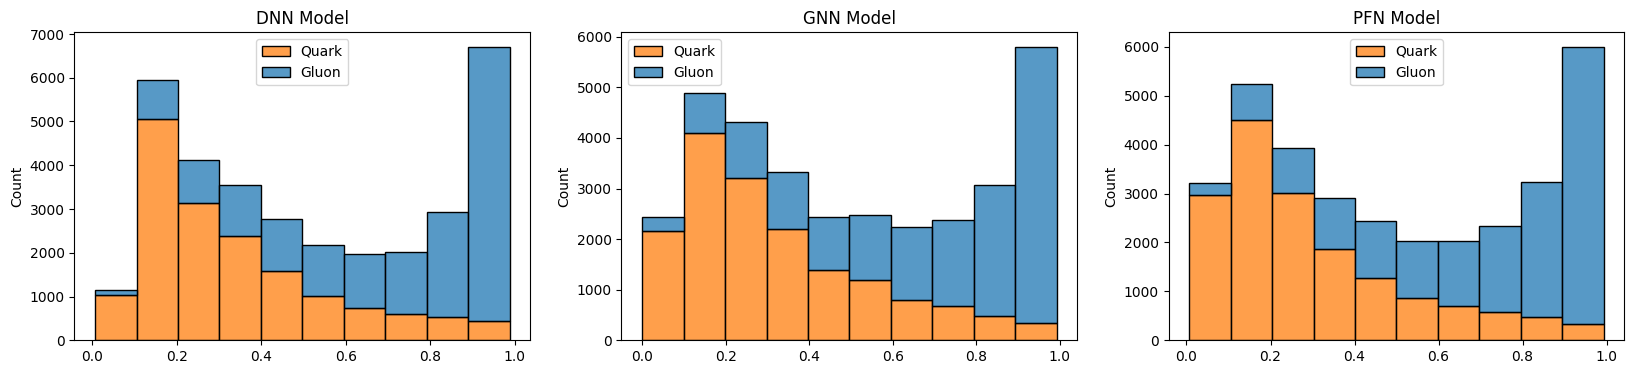

In [49]:
# Here, I compare the distribution of each model

# Now, I compare the confusion matrix of each model
fig, ax = plt.subplots(1,3,figsize=(20,4))

prediction_label = {0: 'pred_DNN_qgid', 1: 'pred_GNN_qgid', 2: 'pred_PFN_qgid'}
label = {0:'DNN Model', 1:'GNN Model', 2:'PFN Model'}
for i in range(3):
    sns.histplot([test_pred_df[test_pred_df['qgid']][prediction_label[i]].tolist(),
              test_pred_df[~test_pred_df['qgid']][prediction_label[i]].tolist()],
              bins=10, multiple='stack', ax=ax[i])
    ax[i].set_title(label[i])
    ax[i].legend(['Quark','Gluon'])

DNN Model ROC AUC = 0.843
GNN Model ROC AUC = 0.839
PFN Model ROC AUC = 0.867


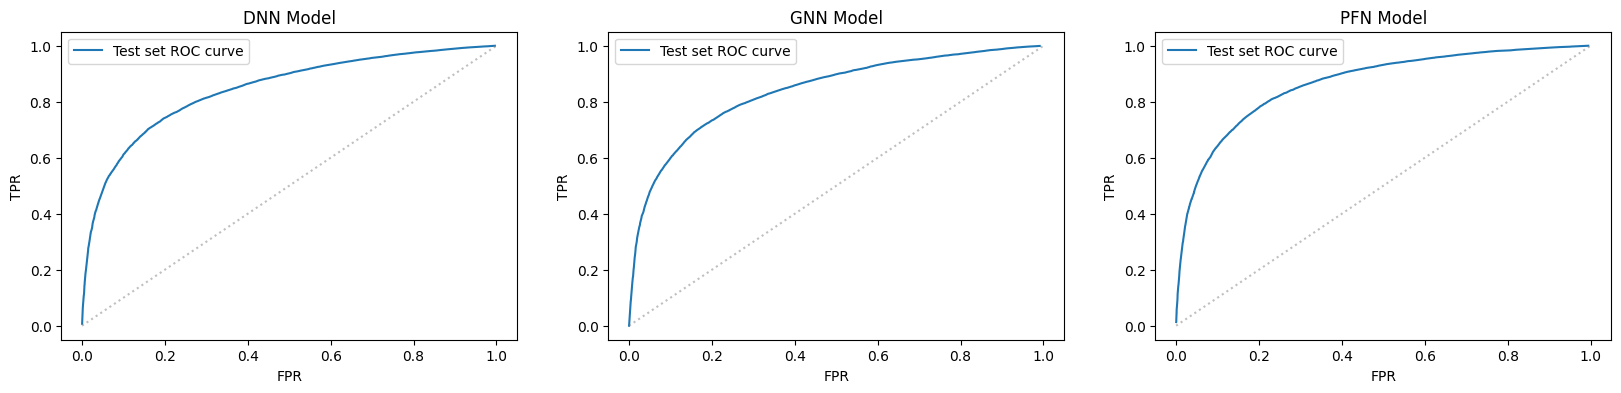

In [52]:
# Compare the ROC curve and ROC AUC of each model

fig, ax = plt.subplots(1,3,figsize=(20,4))

prediction_label = {0: 'pred_DNN_qgid', 1: 'pred_GNN_qgid', 2: 'pred_PFN_qgid'}
label = {0:'DNN Model', 1:'GNN Model', 2:'PFN Model'}
for i in range(3):
    FPR, TPR, _ = sk.metrics.roc_curve( test_pred_df['qgid'].tolist(),test_pred_df[prediction_label[i]].tolist() )
    AUC = sk.metrics.roc_auc_score( test_pred_df['qgid'].tolist(),test_pred_df[prediction_label[i]].tolist() )
    sns.lineplot(pd.DataFrame({'TPR':TPR, 'FPR':FPR}).sample(1000), x='FPR', y='TPR',ax=ax[i])
    ax[i].plot([0,1],[0,1],linestyle=':',color='gray',alpha=0.5)
    ax[i].legend(['Test set ROC curve'])
    ax[i].set_title(label[i])

    print(label[i]+' ROC AUC = %.3f' % (AUC,))

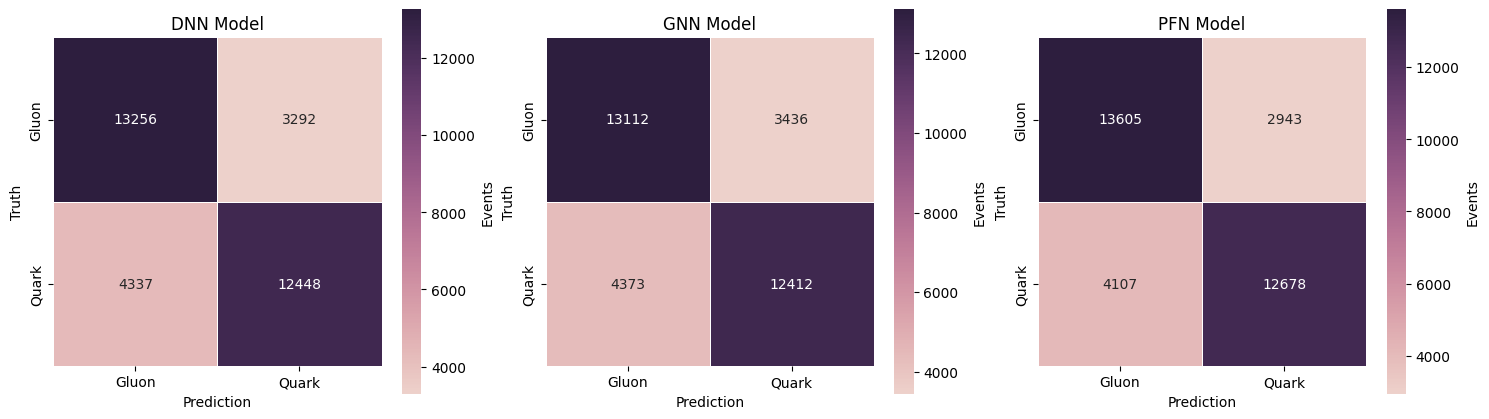

In [51]:
# Now, I compare the confusion matrix of each model
fig, ax = plt.subplots(1,3,figsize=(18,5))

prediction_label = {0: 'pred_DNN_qgid', 1: 'pred_GNN_qgid', 2: 'pred_PFN_qgid'}
label = {0:'DNN Model', 1:'GNN Model', 2:'PFN Model'}
for i in range(3):
    truth, pred = test_pred_df['qgid'], test_pred_df[prediction_label[i]]
    threshold = 0.5

    TP = ( (truth) & (pred>threshold)).sum()
    TN = ( (~truth) & (pred<=threshold)).sum()

    FN = ( (truth) & (pred<=threshold)).sum()
    FP = ( (~truth) & (pred>threshold)).sum()

    matrix = pd.DataFrame({'Truth': ['Quark','Gluon','Quark','Gluon'], 'Prediction': ['Quark','Gluon','Gluon','Quark'], 'Events': [TP,TN,FN,FP]})
    matrix = matrix.pivot(index="Truth", columns="Prediction", values="Events")

    sns.heatmap(matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True), linewidths=.5, cbar_kws={'label':'Events'}, ax=ax[i])
    ax[i].set_title(label[i])
    ax[i].set_box_aspect(1)

## Section 3: Summary

It is clear from the training behavior is that neither the DNN nor the GNN are stable in training. Meanwhile, the PFN model seem to learn at a quick and stable pace.

The comparison that I have shown in the previous cells shows a clear prize winner, in both the ROC AUC values and the confusion matrix comparisons, the PFN model is leading. The PFN, being tailor made for high energy physics discrimination clearly shows in its performance.

When comparing the DNN and the heuristic GNN, the DNN leads ahead by a small margin in the ROC AUC. This implies that the heuristic approach and the implementation of the GNN is sub-optimal, or that the classical GNN approach is not sufficient for our case study.

In regards to the sampled dataset, increasing the statistics will probably imrpove the prediction of all models, but the comparison is expected to be relatively similar, since the rest of the dataset is not larger by a huge margin (4 times the dataset used in this notebook)